# Professor Research and Student Success

## By Diego Piraquive, James Firpo and Trevor Teerlink
https://youtu.be/bEZXJZtDEuc


The University of Utah is known for its excellence in academic research, and claims "Research is a major component in the life of the U benefiting students as well as the region. The University of Utah is ranked 47th in the U.S. and 87th in the world in the 2014 Academic Ranking of World Universities." - (http://research.utah.edu/).  As 3 students who are wrapping up our senior year in mechanical engineering and Mathematics, we sometimes wonder how much University research REALLY benefits students.  Yes, of course we all feel that being involved in reserach is beneficial to our learning, but it often feels that professors are so devoted to research, that it reduces the time and energy put into teaching.  Sit in on some of these professors's classes, and you might find its not that they have a BAD teaching style, its just that theres NO teaching style.  It is very much a presentation of information, whith little transfer of enthusiasm.  

The purpose of our project is to search for any correlations between the amount of time a professor spends on research, and detect if this has an effect on their students.  We have a suspicion that professors who are heavily involved in research, have less commitment to their students, which may be reflected through poorer student performance.

We have two sources we are scraping from.  The OBIA (Office of Budget and Institutional Analysis), and a factory directory website, which contains links to every professor's Google Scholar account.  From the OBIA we will scrape classes, the class professor, and the class grades.  From the Faculty directory and google scholar links, we will attain an "h-index" for each professor.  The h-index is an author-level metric that attempts to measure both the productivity and citation impact of the publications of a scientist or scholar. The index is based on the set of the scientist's most cited papers and the number of citations that they have received in other publications.  We therefore find the h-index to be a good indicator of a professor's involvment in research, and their "time spent away from teaching".

After the data is collected, we then use linear regression, and correlation matrices to analyze the relation between the h-index and student grades.  This was done for all the professors, and their respective classes in the Mechanical Engineering program.  

In conclusion, we found that the data did not support our theoery as much as we had hoped, but perhaps this reveals new information that student scores are not highly affected by professor research.




### Obtaining h-index

In the cell below, we demonstrate we can scrape a common faculty directory, https://mech.utah.edu/faculty/.
The code builds two functions:  one function to get the h-index from google scholar, and the second function
navigates to grab all the the google scholar urls from the faculty page.  We then employ these funcitons together to obtain the h-index.

In [1]:



import urllib.request
from bs4 import BeautifulSoup



def get_hindex(url):
    scholar_soup = BeautifulSoup(urllib.request.urlopen(url), 'lxml')
    return int(scholar_soup.findAll("td", {"class": "gsc_rsb_std"})[2].text)



def get_prof_scores():
    soup = BeautifulSoup(urllib.request.urlopen("https://mech.utah.edu/faculty/"), 'lxml')

    for row in soup.find("table", {"id": "tablepress-7"}).findAll("tr"):
        tds = row.findAll("td")
        if len(tds) == 0:
            continue

        _, name, body, _ = tds
        link = body.find("a")
        if not link:
            continue
        url = link["href"]
      

        yield (name.find("strong").text.strip(), get_hindex(url))

prof_scores = list(get_prof_scores())

print(prof_scores)

[('Jake Abbott', 28), ('Claire Acevedo', 9), ('Tim Ameel', 27), ('Rebecca Brannon', 17), ('Marc Calaf', 9), ('Jiyoung Chang', 11), ('Brittany Coats', 12), ('Michael Czabaj', 9), ('Mathieu Francoeur', 21), ('Henry Fu', 17), ('Bruce Gale', 34), ('Owen Kingstedt', 4), ('Yong Lin Kong', 7), ('Kam K. Leang', 31), ('Tommaso Lenzi', 22), ('Stephen Mascaro', 17), ('Patrick McMurtry', 26), ('Sanford G. Meek', 21), ('Andrew Merryweather', 11), ('Mark A. Minor', 20), ('Ken Monson', 12), ('Steven Naleway', 10), ('Pania Newell', 8), ('Eric Pardyjak', 26), ('Keunhan (Kay) Park', 18), ('Bart Raeymaekers', 15), ('Shad Roundy', 20), ('Amanda Smith', 10), ('Ashley Spear', 5), ('Rob Stoll', 11), ('Wenda Tan', 7), ('Roseanne Warren', 6)]


### Obtain class and grades data from OBIA files
Now we have a list of all the Mechanical Engineering professors and their h-index score.  
This is a very handy metric to show how dedicated a professor is to research.

Below, we begin assembling the data from the OBIA website, and cleaning as we go.  We first grab CSV files from the site, and then begin dropping un-wanted columns. 

In [2]:
from bs4 import BeautifulSoup
import requests
import urllib.request

import time
import pandas as pd
import scipy as sc
import numpy as np
import re

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [3]:
#gets the dataframe from the csv, cleans supressed data

def getgrades(csv1):
    grades1=pd.read_csv(csv1, encoding="utf8")
    #grades2=pd.read_csv(csv2, encoding="utf8")
    #grds=[grades1, grades2]
    #grades=pd.concat(grds,ignore_index=True)
    i=0
    #grades=grades.reset_index(drop=True)
    hc=grades1['sumHeadcount']
    while i < len(hc):
        if hc[i]== 'ds':
            grades1=grades1.drop(i, axis=0)
        i+=1
    grades=grades1.reset_index(drop=True)
    return(grades)

In [4]:
#puts all of the grades for each class on one line
def combinegrades(grades):
    i=1
    n=2
    gradesclean=pd.DataFrame([],columns=['Cat. #', 'Sec.', 'Subject', 'A', 'B', 'C', 'D', 'E', 'W', 'Other'])
    gradesclean=gradesclean.append({'Cat. #':grades['Catalog Num'][0], 'Sec.':grades['Section'][0], 'Subject':grades['Subject'][0], 'A':0, 'B':0, 'C':0, 'D':0,
                                    'E':0, 'W':0, 'Other':0}, ignore_index=True)
    gradesclean[grades['Grade Group'][0]][0]=grades['sumHeadcount'][0]
    while i<len(grades['sumHeadcount']):
        if grades['Subject'].iloc[i]==gradesclean['Subject'].iloc[-1]:
            if grades['Catalog Num'].iloc[i]==gradesclean['Cat. #'].iloc[-1]:
                fail=0
                for m in range(1,n):
                    if grades['Section'].iloc[i]==gradesclean['Sec.'].iloc[-m]:
                        gradesclean[grades['Grade Group'].iloc[i]].iat[-m]=grades['sumHeadcount'].iloc[i]
                        break
                    fail+=1
                if fail==n-1:
                    n+=1
                    gradesclean=gradesclean.append({'Cat. #':grades['Catalog Num'].iloc[i],
                                                    'Sec.':grades['Section'].iloc[i],
                                                    'Subject':grades['Subject'].iloc[i], 'A':0, 'B':0,
                                                    'C':0,'D':0, 'E':0, 'W':0, 'Other':0}, ignore_index=True)
                    gradesclean[grades['Grade Group'].iloc[i]].iat[-1]=grades['sumHeadcount'].iloc[i]
            else:
                n=2
                gradesclean=gradesclean.append({'Cat. #':grades['Catalog Num'].iloc[i], 'Sec.':grades['Section'].iloc[i],
                                                'Subject':grades['Subject'].iloc[i], 'A':0, 'B':0,
                                                'C':0,'D':0, 'E':0, 'W':0, 'Other':0}, ignore_index=True)
                gradesclean[grades['Grade Group'].iloc[i]].iat[-1]=grades['sumHeadcount'].iloc[i]
        else:
            n=2
            gradesclean=gradesclean.append({'Cat. #':grades['Catalog Num'].iloc[i], 'Sec.':grades['Section'].iloc[i],
                                            'Subject':grades['Subject'].iloc[i], 'A':0, 'B':0,
                                            'C':0,'D':0, 'E':0, 'W':0, 'Other':0}, ignore_index=True)
            gradesclean[grades['Grade Group'].iloc[i]].iat[-1]=grades['sumHeadcount'].iloc[i]
        i+=1
    return(gradesclean)

In [5]:
#only code that needs to be edited to add new data
egrades=['MEN F17.csv','MEN S17.csv','MEN F16.csv','MEN S16.csv','MEN F15.csv','MEN S15.csv','MEN F14.csv','MEN S14.csv','MEN F13.csv']
i=0
cleaned=[0,0,0,0,0,0,0,0,0]
while i<len(egrades):
    gradess=getgrades(egrades[i])
    gradescleans=combinegrades(gradess)
    cleaned[i]=gradescleans
    i+=1


### Relating professor names to class numbers
We used the course catalog to scrape course numbers and professor names, in a similar fasion to how we did in lecture. This made it possible to connect course numbers with their corresponding professor.  To caputre all the classes in the catalog, we needed to scroll through the entire page, which prevented us from scraping.  We first tried using a program called Selenium, but quickly learned we needed java experience to use it.  To solve the problem, we manually downloaded, and modified the html code to extract all the ME EN courses. 

In [6]:
#combines the instructor frame and the grades frame, removes classes taught by graduate students

def instruct(excel, working):
    F17t=pd.read_excel(excel)
    i=0
    working['Instructor']= ['ds']*len(working['A'])
    while i<len(working['A']):
        m=0
        while m<len(F17t['Sec.']):
            if working['Cat. #'].iloc[i] == F17t['Cat. #'].iloc[m]:
                if working['Sec.'].iloc[i] == F17t['Sec.'].iloc[m]:
                    working.at[i,'Instructor']= F17t['Instructor'].iloc[m].partition(',')[0]
            m+=1
        i+=1
    i=0
    while i<len(working['A']):
        if working['Instructor'].iloc[i] == 'ds':
            working=working.drop(i, axis=0)
        i+=1
    working=working.reset_index(drop=True)
    return(working)

In [7]:
#only code that needs to be edited to add more data
excels=['F17_meen_classes.xlsx','S17_meen_classes.xlsx','F16_meen_classes.xlsx',
        'S16_meen_classes.xlsx','F15_meen_classes.xlsx','S15_meen_classes.xlsx',
        'F14_meen_classes.xlsx','S14_meen_classes.xlsx','F13_meen_classes.xlsx']
insts=[]
i=0
while i<9:
    insts.append(instruct(excels[1],cleaned[1]))
    i+=1
insts[0]['Sem']= ['F17']*len(insts[0]['A'])
insts[1]['Sem']= ['S17']*len(insts[1]['A'])
insts[2]['Sem']= ['F16']*len(insts[2]['A'])
insts[3]['Sem']= ['S16']*len(insts[3]['A'])
insts[4]['Sem']= ['F15']*len(insts[4]['A'])
insts[5]['Sem']= ['S15']*len(insts[5]['A'])
insts[6]['Sem']= ['F14']*len(insts[6]['A'])
insts[7]['Sem']= ['S14']*len(insts[7]['A'])
insts[8]['Sem']= ['F13']*len(insts[8]['A'])
finished=pd.concat(insts,ignore_index=True)
mask=finished['Instructor'] != 'ds'
finished=finished[mask]
finished=finished.reset_index(drop=True)

In [8]:
#takes the h-index list and combines it with the instrutors and grades, removes instructors that don't have a h-index

hscore=[('ABBOTT', 28), ('ACEVDO', 8), ('AMEEL', 27), ('BRANNON', 17),
 ('CALAF', 9), ('CHANG', 11), ('COATS', 12), ('CZABAJ', 9),
 ('FRANCOEUR', 21), ('FU', 17), ('GALE', 34), ('KINGSTEDT', 4),
 ('KONG', 6), ('LEANG', 31), ('LENZI', 22), ('MASCARO', 17),
 ('MCMURTRY', 26), ('MEEK', 21), ('MERRYWEATHER', 11), ('MINOR', 21),
 ('MONSON', 12), ('NALEWAY', 10), ('NEWELL', 8), ('PARDYJAK', 26), 
 ('PARK', 18), ('RAEYMAEKERS', 15), ('ROUNDY', 20), ('SMITH', 10),
 ('SPEAR', 5), ('STOLL', 11), ('TAN', 7), ('WARREN', 6)]
i=0
finished['h-score']= ['ds']*len(finished['A'])
while i < len(finished['Sem']):
    for m in hscore:
        if m[0] == finished['Instructor'].iloc[i]:
            finished.at[i,'h-score']= m[1]
    i+=1
mask=finished['h-score'] != 'ds'
finished=finished[mask]
finished=finished.reset_index(drop=True)
finished

Cat. # Sec.                         Subject   A   B   C   D   E   W Other  \
0     1000    1  ME EN - Mechanical Engineering  32   8   2   1   1   0     0   
1     1010    1  ME EN - Mechanical Engineering  56  40  21  10   4  11     0   
2     2010    1  ME EN - Mechanical Engineering  34  43  28  30   9   7     1   
3     2960    1  ME EN - Mechanical Engineering   5   0   0   0   1   0     0   
4     2960    3  ME EN - Mechanical Engineering   6   0   0   0   0   0     0   
5     3000    1  ME EN - Mechanical Engineering  26  41  29   8  14   0     0   
6     3210    1  ME EN - Mechanical Engineering  24  74  30   1   0   0     1   
7     3220    1  ME EN - Mechanical Engineering  13  42   9   2   3   0     0   
8     3300    1  ME EN - Mechanical Engineering  16  37  13   1   6   1     1   
9     3600    1  ME EN - Mechanical Engineering  17  25  24   6   7   1     0   
10    3650    1  ME EN - Mechanical Engineering  31  36  29  10   3   2     0   
11    3700    1  ME EN - Mechanical Engineering   8  24  17   0   2   1     0   
12    4000    1  ME EN - Mechanical Engineering  66   3   0   0   0   0     0   
13    4010    1  ME EN - Mechanical Engineering  55  75   2   0   0   0     0   
14    5210    1  ME EN - Mechanical Engineering   3  11   3   0   0   0     0   
15    5230    1  ME EN - Mechanical Engineering   3   3   0   0   0   0     0   
16    5400    1  ME EN - Mechanical Engineering   8   8   2   0   0   0     0   
17    5520    1  ME EN - Mechanical Engineering   8  33  25   3   2   0     0   
18    5960    4  ME EN - Mechanical Engineering  12   2   1   0   0   0     0   
19    5960    3  ME EN - Mechanical Engineering   6   8   2   0   0   0     0   
20    5960    2  ME EN - Mechanical Engineering   3   3   1   0   0   0     0   
21    5960    1  ME EN - Mechanical Engineering   5   8   0   0   0   0     0   
22    1000    1  ME EN - Mechanical Engineering  32   8   2   1   1   0     0   
23    1010    1  ME EN - Mechanical Engineering  56  40  21  10   4  11     0   
24    2010    1  ME EN - Mechanical Engineering  34  43  28  30   9   7     1   
25    2960    1  ME EN - Mechanical Engineering   5   0   0   0   1   0     0   
26    2960    3  ME EN - Mechanical Engineering   6   0   0   0   0   0     0   
27    3000    1  ME EN - Mechanical Engineering  26  41  29   8  14   0     0   
28    3210    1  ME EN - Mechanical Engineering  24  74  30   1   0   0     1   
29    3220    1  ME EN - Mechanical Engineering  13  42   9   2   3   0     0   
..     ...  ...                             ...  ..  ..  ..  ..  ..  ..   ...   
168   5210    1  ME EN - Mechanical Engineering   3  11   3   0   0   0     0   
169   5230    1  ME EN - Mechanical Engineering   3   3   0   0   0   0     0   
170   5400    1  ME EN - Mechanical Engineering   8   8   2   0   0   0     0   
171   5520    1  ME EN - Mechanical Engineering   8  33  25   3   2   0     0   
172   5960    4  ME EN - Mechanical Engineering  12   2   1   0   0   0     0   
173   5960    3  ME EN - Mechanical Engineering   6   8   2   0   0   0     0   
174   5960    2  ME EN - Mechanical Engineering   3   3   1   0   0   0     0   
175   5960    1  ME EN - Mechanical Engineering   5   8   0   0   0   0     0   
176   1000    1  ME EN - Mechanical Engineering  32   8   2   1   1   0     0   
177   1010    1  ME EN - Mechanical Engineering  56  40  21  10   4  11     0   
178   2010    1  ME EN - Mechanical Engineering  34  43  28  30   9   7     1   
179   2960    1  ME EN - Mechanical Engineering   5   0   0   0   1   0     0   
180   2960    3  ME EN - Mechanical Engineering   6   0   0   0   0   0     0   
181   3000    1  ME EN - Mechanical Engineering  26  41  29   8  14   0     0   
182   3210    1  ME EN - Mechanical Engineering  24  74  30   1   0   0     1   
183   3220    1  ME EN - Mechanical Engineering  13  42   9   2   3   0     0   
184   3300    1  ME EN - Mechanical Engineering  16  37  13   1   6   1     1   
185   3600    1  ME EN - Mechanical

### Data analysis through linear regression and correlation
We have now collected all relevant class, professor, and student information.  We perform linear regression to uncover the existance of any possible correlations between h-index and student scores.

In [9]:
#libraries
import scipy as sc
from scipy.stats import norm

import pandas as pd
import statsmodels.formula.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [10]:

#read in cleaned up data
data = pd.read_csv('h-scored.csv')
#drop the old index and subject since they're all ME
data = data.drop(['Unnamed: 0', 'Subject','Sec.','Cat. #','Sem'],axis = 1)
data['h_score']=data['h-score']

In [11]:
#In order to later use the OLS 
data = data.drop(['h-score'],axis = 1)

In [12]:

data['# of Students'] = data['A']+data['B']+data['C']+data['D']+data['E']

In [13]:
data['Average_GPA'] = ((data['A']*4.0)+(data['B']*3.0)+(data['C']*2.0)+(data['D']*1)+(data['E']*0))/(data['# of Students'])


### Correlation Matrix
This will show visually how the h-index affects student scores

In [14]:
#create a dataframe of the two variables we are interested in their coorelation
relevant_data = data[['h_score','Average_GPA']]

              h_score  Average_GPA
h_score      1.000000    -0.348802
Average_GPA -0.348802     1.000000


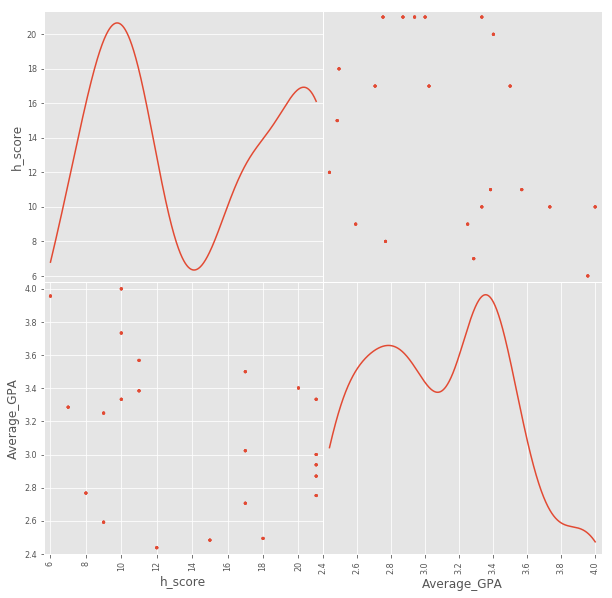

In [15]:
#ex
print(relevant_data.corr())
pd.plotting.scatter_matrix(relevant_data, figsize=(10, 10), diagonal='kde')
plt.show()

In [16]:
Grades_ols = sm.ols(formula="Average_GPA ~ h_score", data=relevant_data).fit()
Grades_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Average_GPA   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     27.15
Date:                Sun, 22 Apr 2018   Prob (F-statistic):           4.75e-07
Time:                        16:41:50   Log-Likelihood:                -112.59
No. Observations:                 198   AIC:                             229.2
Df Residuals:                     196   BIC:                             235.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5619      0.089     40.129      0.000       3.387       3.737
h_score       -0.0306      0.006     -5.210      0.000      -0.042      -0.019
==============================================================================
Omnibus:                       31.118   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.072
Skew:                          -0.195   Prob(JB):                       0.0107
Kurtosis:                       2.026   Cond. No.                         44.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

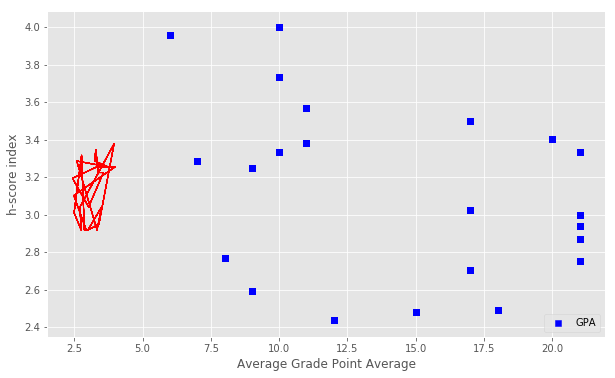

In [17]:
plt.scatter(x=data['h_score'],y=data['Average_GPA'],c='b',marker='s',label='GPA')
plt.legend(numpoints=1,loc=4)
plt.plot(data['Average_GPA'],Grades_ols.predict(),c='r',linewidth=1)

plt.xlabel('Average Grade Point Average')
plt.ylabel('h-score index')
plt.show()


Using our model, this plot shows a predection of student GPA based on the h-score of a professor.  It is evident that the model cannont accurately predict student scores given a professor's h-index.

#### CONCLUSION

From the analysis, we can see that the h-index, does not conclusively affect student scores quite as strongly as we had hoped, with a correlation of negative %34.  This means, essentially, that only 34% of the data supports our hypothesis that the averages grades are lower for a class whose professor spends more time doing research.  Being that random data has an expected correlation of 50%, we can conclude that this data does not support that a conclusion can be made.  Unfortunately we were not able to prove our initial hypothessis, but through the data analysis, we can propose another hypothesis that a professor's involvment in research does not academicly affect student scores.